In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import ast
import pyvisa
import time
from bs4 import BeautifulSoup #aid in html reading
import urllib.request #to open URLs 
import os
import csv
from scipy.optimize import curve_fit

In [2]:
url = 'http://10.10.15.22/cgi-bin/ope/allch.cgi'  #url of the yokogawa (truta) containing the voltage values

def yoko_readings():
    
    html = urllib.request.urlopen(url).read() #open url and read it
    soup = BeautifulSoup(html, 'html.parser') #parse the html

    tables = soup.find_all('table') #find the table in the html content
    table = tables[1] #there are 2 tables in the html content, we're interested in the second one (has the voltage values)

    td_elements = table.find_all('td', align='center') #this block of code is getting the values of the voltage by narrwoing down on
    voltage_values = []                                #some elements that their code lines have in common: 'td', 'center', 
    for td in td_elements:                             #'b', and not having 'width'. 
        b = td.find('b')                               
        if b:
            try:
                value = float(b.text.strip())
                if 'width' not in td.attrs:
                    voltage_values.append(value)
            except ValueError:
                pass
    
    return voltage_values[1]

In [3]:
rm = pyvisa.ResourceManager()
keithley = rm.open_resource('USB0::0x05E6::0x2450::04636373::0::INSTR') #Current Source Channel 3

keithley.write('*RST')
keithley.write(':SOUR:FUNC CURR')  # Set the source function to current
keithley.write('SOUR:CURR:DEL:AUTO OFF')
keithley.write('SOURce:CURRent:READ:BACK ON')
keithley.write('SOURce:CURRent:VLIM 21')
keithley.write(':ROUT:TERM REAR')  # Set the output terminals to the rear panels
keithley.write(':OUTP ON')  # Turn on the output

10

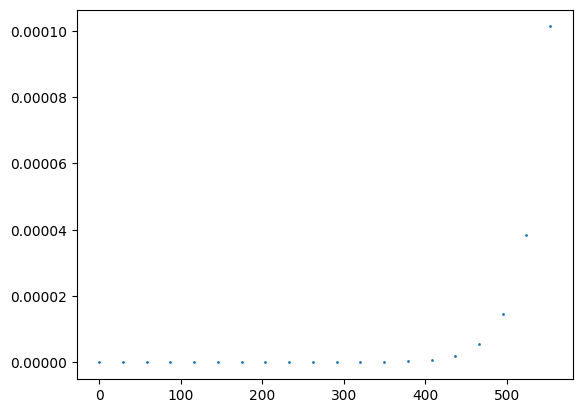

In [4]:
def exponential_current(t, I0, T):
    return I0 * np.exp(t / T)

t = np.linspace(0,553,20)
correntes = exponential_current(t=t, I0 = 10**-12, T=30)
plt.scatter(t, correntes,s=1)
plt.show()

In [7]:
t0=time.time()
log_lin_current = [[i] for i in correntes]
times = []
for j in range(1, len(correntes)+1):
    t1=time.time()
    keithley.write(f'SOURce:CURRent {correntes[-j]}')
    print('sourced:', correntes[-j])
    time.sleep(15)
    keithley.query('*OPC?')
    time.sleep(15)
    t2 = time.time()
    while time.time()-t2<30:
        v = yoko_readings()
        i = 10**((v-15)/1.25)
        log_lin_current[j-1].append(i)
        print('read: ', i)
        time.sleep(0.125)
    times.append(time.time()-t0)

sourced: 0.00010127329720485311
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.799411610955963e-05
read:  9.79

In [15]:
with open('log_lin_currents.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(zip(correntes, log_lin_current))

In [62]:
len(correntes), len(log_lin_current)

(20, 20)

In [71]:
for i in log_lin_current:
    if len(i) > 150:
        if len(i)==151:
            del[i[0]]
        else:
            del[i[1]]
            del[i[0]]

for i in log_lin_current:
    print(len(i))

150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150


In [75]:
"""averages_x = 
averages_y = []
variances_y = []
stdvs_y = []
covariance_xy=[]

for i in range(len(log_lin_current)):
    averages_y.append(sum(log_lin_current[i])/len(log_lin_current[i]))
    sum_var=0
    sum_covar = 0
    for j in range(len(log_lin_current[i])):
        sum_var += (log_lin_current[i][j]-averages_y[i])**2
        sum_covar += (log_lin_current[i][j]-averages_y[i])*()

    variances_y.append(sum_var/len(log_lin_current[i]))
    stdvs_y.append(math.sqrt(variances_y[i]))""""Dados KeithleyAFG"

means = np.array([np.mean(readings) for readings in log_lin_current])
std_devs = np.array([np.std(readings) for readings in log_lin_current])
std_devs[std_devs == 0] = 1e-25
std_devs

array([1.99927808e-16, 2.01325822e-16, 1.11331541e-16, 5.52768608e-13,
       1.02418704e-13, 1.67574377e-14, 5.10749103e-14, 6.46605641e-13,
       4.13590306e-25, 1.95893895e-12, 1.00000000e-25, 6.78277815e-12,
       1.03833688e-10, 1.93152864e-10, 4.45068637e-10, 1.93964062e-09,
       3.63798119e-09, 4.75755132e-09, 1.94332947e-08, 3.54055503e-08])

In [76]:
def linear_model(x, a, b):
    return a * x + b

weights = 1 / std_devs  # Inverse of the standard deviation as weights
params, covariance = curve_fit(linear_model, correntes, means, sigma=std_devs, absolute_sigma=True)
slope, intercept = params
slope_error, intercept_error = np.sqrt(np.diag(covariance))

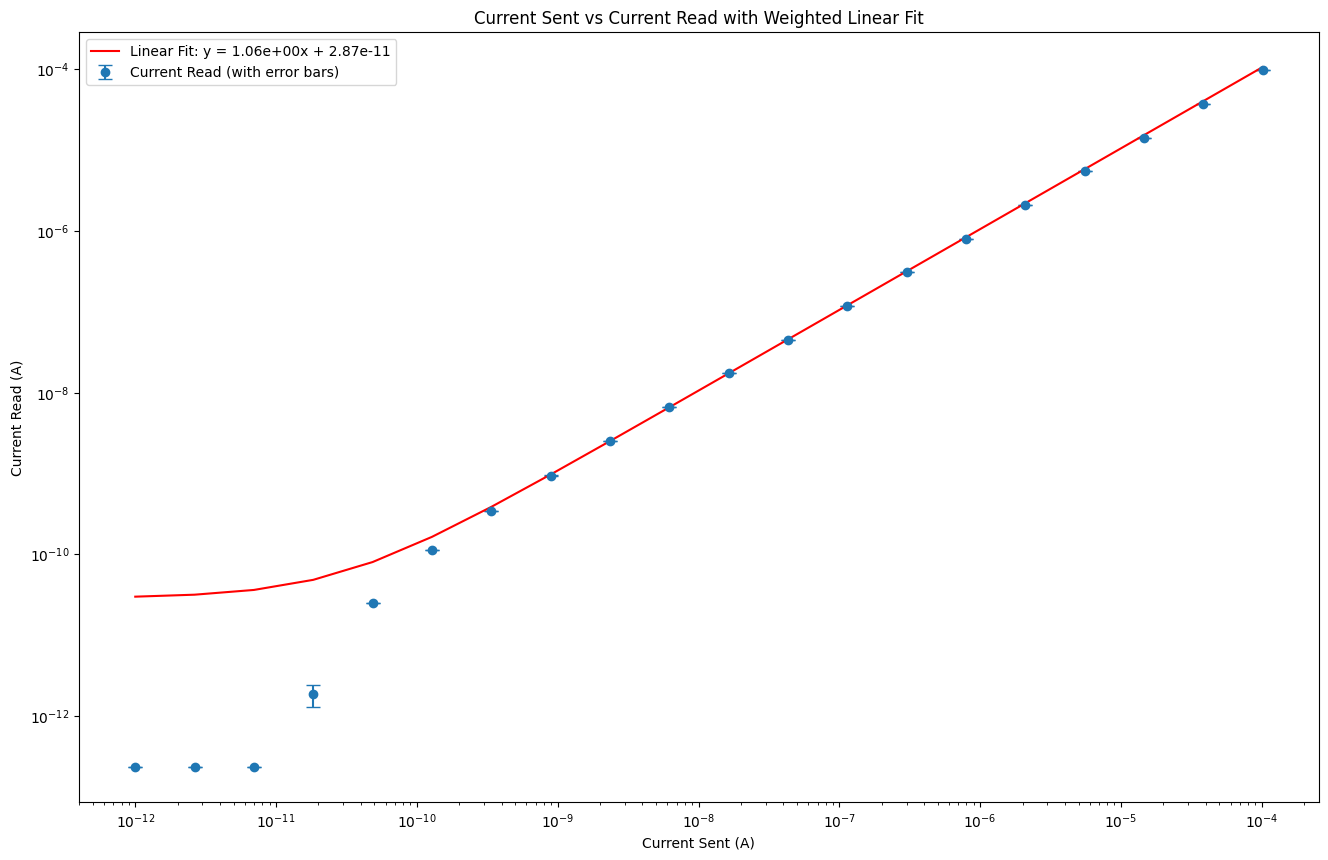

In [82]:
# Generate the fit line
fit_line = linear_model(correntes, slope, intercept)

# Plotting
plt.figure(figsize=(16,10), dpi=100)
plt.errorbar(correntes, means, yerr=std_devs, fmt='o', label='Current Read (with error bars)', capsize=5)
plt.plot(correntes, fit_line, 'r-', label=f'Linear Fit: y = {slope:.2e}x + {intercept:.2e}')
plt.xlabel('Current Sent (A)')
plt.ylabel('Current Read (A)')
plt.xscale('log')
plt.yscale('log')
plt.title('Current Sent vs Current Read with Weighted Linear Fit')
plt.legend()

# Save and show the plot
#plt.savefig('current_vs_read_weighted_fit.pdf', bbox_inches='tight')
plt.show()